## Predicting El Niño - LSTM Model

After analyzing our dataset, we proceed to create a regression model to predict the Oceanic Nino Index (ONI), and we will follow these three steps:

1. Read and clean the data
2. Train Model using Long-Short Term Memory (LSTM) Neural Network
3. Predict and evaluate the model

### 1. Read and clean the data

Firstly we will import the required libraries to process the dataset.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os.path
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from math import sqrt

warnings.filterwarnings('ignore')

df = pd.read_csv('Data.csv')

# Create a function to convert parse the date variable
def date_parser(x):
    if str(x).endswith('10') or str(x).endswith('11') or str(x).endswith('12'):
        return pd.datetime.strptime(str(x),'%Y%m')
    else:
        return pd.datetime.strptime(str(x),'%Y0%m')

df['date'] = df['date'].apply(date_parser)

# And now convert date to index
df = df.set_index('date')

# We are going to use data from 1979, and standardize the value
start = 336
df = df.iloc[start:]
df = (df - df.mean())/df.std()

cols = df.columns.tolist()
cols = cols[1:] + cols[:1]
df = df[cols]

df.head()

Using TensorFlow backend.


,oni,nino3,pna,precip,soi
date,,,,,
1979-01-01,-0.059963,-0.150376,-1.537109,1.424196,-0.441750
1979-02-01,0.056451,-0.271512,-2.725606,0.200227,0.997371
1979-03-01,0.172865,-0.139364,0.080846,-0.530831,0.072222
1979-04-01,0.289280,0.213033,-0.148864,-0.755133,-0.133367
1979-05-01,0.172865,0.036835,1.269344,-0.270530,0.483399


We are going to use a supervised learning algorithm to predict SOI. For time series, we must avoid autocorrelation by using a technique called sliding (or lag) window. The sliding lag window could grab NaN values, those should be discarded.

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i).iloc[:,-1])
        if i == 0:
            names += ['VAR(t)']
        else:
            names += ['VAR(t+%d)' % i]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# specify the size of our sliding window and number of features
enso = df.values.astype('float32')
lag = 12
ahead = 3
n_features = 1
reframed = series_to_supervised(enso, lag, ahead)
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),...,var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),VAR(t),VAR(t+1),VAR(t+2)
12,-0.059963,-0.150376,-1.537109,1.424196,-0.441750,0.056451,-0.271512,-2.725606,0.200227,0.997371,...,0.061769,-0.441750,0.638523,0.587453,-0.678194,-0.032382,-0.750133,0.380605,0.277811,-0.441750
13,0.056451,-0.271512,-2.725606,0.200227,0.997371,0.172865,-0.139364,0.080846,-0.530831,0.072222,...,-0.032382,-0.750133,0.638523,0.411255,-1.007778,-0.076689,0.380605,0.277811,-0.441750,-0.647339
14,0.172865,-0.139364,0.080846,-0.530831,0.072222,0.289280,0.213033,-0.148864,-0.755133,-0.133367,...,-0.076689,0.380605,0.522109,-0.029240,2.028384,-0.804978,0.277811,-0.441750,-0.647339,-0.030572
15,0.289280,0.213033,-0.148864,-0.755133,-0.133367,0.172865,0.036835,1.269344,-0.270530,0.483399,...,-0.804978,0.277811,0.289280,-0.194425,-0.638245,0.269456,-0.441750,-0.647339,-0.030572,-0.030572
16,0.172865,0.036835,1.269344,-0.270530,0.483399,-0.059963,0.279107,-1.636982,-0.068382,0.586194,...,0.269456,-0.441750,0.405694,-0.007215,1.658851,-0.359143,-0.647339,-0.030572,-0.030572,-0.030572


In [4]:
def fit_lstm(train, n_lag, n_ahead, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, :-n_ahead], train[:, -n_ahead:]
    X = X.reshape(X.shape[0], n_lag, int(X.shape[1]/n_lag))

    # design neural network architecture. This is a simple LSTM just for demo purpose
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(n_ahead))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit the NN
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=2, shuffle=False)
        model.reset_states()
    return model

In [5]:
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

# fit a LSTM model with the transformed data
# model fitting can be very time-consuming, therefore a pre-trained model is included in the data folder
if not os.path.exists('my_model.h5'):
    model = fit_lstm(train, lag, ahead, 1, 30, 30)
    model.save('my_model.h5')
else:
    model = load_model('my_model.h5')

Epoch 1/1
 - 6s - loss: 0.7371
Epoch 1/1
 - 5s - loss: 0.5930
Epoch 1/1
 - 4s - loss: 0.5433
Epoch 1/1
 - 4s - loss: 0.5038
Epoch 1/1
 - 4s - loss: 0.4829
Epoch 1/1
 - 4s - loss: 0.4609
Epoch 1/1
 - 4s - loss: 0.4417
Epoch 1/1
 - 4s - loss: 0.4167
Epoch 1/1
 - 4s - loss: 0.3980
Epoch 1/1
 - 4s - loss: 0.3954
Epoch 1/1
 - 5s - loss: 0.3763
Epoch 1/1
 - 4s - loss: 0.3708
Epoch 1/1
 - 4s - loss: 0.4021
Epoch 1/1
 - 4s - loss: 0.3778
Epoch 1/1
 - 4s - loss: 0.3488
Epoch 1/1
 - 4s - loss: 0.3387
Epoch 1/1
 - 4s - loss: 0.3279
Epoch 1/1
 - 4s - loss: 0.3238
Epoch 1/1
 - 4s - loss: 0.2970
Epoch 1/1
 - 4s - loss: 0.2988
Epoch 1/1
 - 4s - loss: 0.2964
Epoch 1/1
 - 4s - loss: 0.2769
Epoch 1/1
 - 5s - loss: 0.2924
Epoch 1/1
 - 4s - loss: 0.2592
Epoch 1/1
 - 4s - loss: 0.2451
Epoch 1/1
 - 4s - loss: 0.2378
Epoch 1/1
 - 4s - loss: 0.2380
Epoch 1/1
 - 4s - loss: 0.2482
Epoch 1/1
 - 4s - loss: 0.2472
Epoch 1/1
 - 4s - loss: 0.2687


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 30)                   4320      
_________________________________________________________________
dense_1 (Dense)              (1, 3)                    93        
Total params: 4,413
Trainable params: 4,413
Non-trainable params: 0
_________________________________________________________________


In [7]:
# predict the SOI values for next three time steps given a single input sample 
def forecast_lstm(model, X, n_batch, n_lag):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, n_lag, int(len(X)/n_lag))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# make prediciton for a list of input samples
def make_forecasts(model, n_batch, train, test, n_lag, n_ahead):
    forecasts = list()
    for i in range(len(test)):
        X = test[i, :-n_ahead]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch, n_lag)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [8]:
forecasts = make_forecasts(model, 1, train, test, lag, ahead)
# pring out the output for the first input sample
forecasts[0]

[-1.2067518, -1.4292138, -1.3842845]

In [9]:
def evaluate_forecasts(y, forecasts, n_lag, n_seq):
    print('Evaluation results (RMSE) for each next tim step:')
    for i in range(n_seq):
        actual = [row[i] for row in y]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d time step: %f' % ((i+1), rmse))
        
# evaluate forecasts
actual = [row[-ahead:] for row in test]
evaluate_forecasts(actual, forecasts, lag, ahead)

Evaluation results (RMSE) for each next tim step:
t+1 time step: 0.813492
t+2 time step: 0.839545
t+3 time step: 0.891894


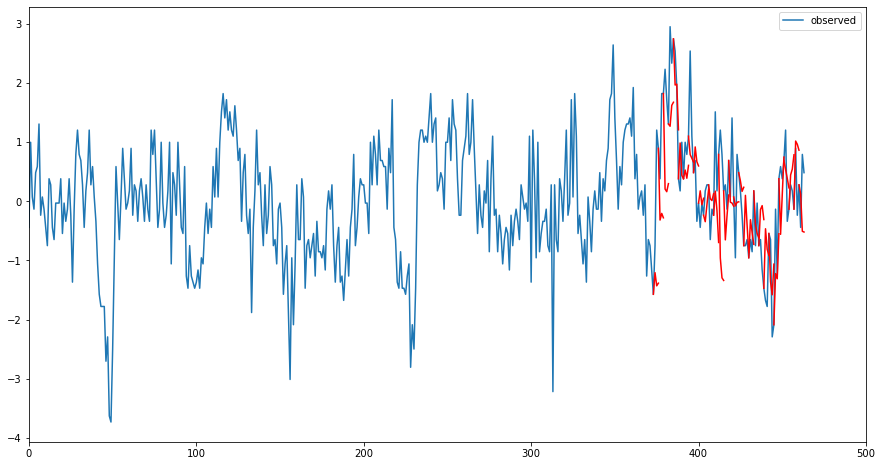

In [10]:
def plot_forecasts(series, forecasts, n_test, xlim, ylim, n_ahead, linestyle = None):
    plt.figure(figsize=(15,8))
    if linestyle==None:
        plt.plot(series, label='observed')
    else:
        plt.plot(series, linestyle, label='observed')
    plt.xlim(xlim, ylim)
    plt.legend(loc='upper right')
    # plot the forecasts in red
    for i in range(len(forecasts)):
        # this ensures not all segements are plotted, it is plotted every n_ahead
        if i%n_ahead ==0:
               off_s = len(series) - n_test + 2 + i - 1
               off_e = off_s + len(forecasts[i]) + 1
               xaxis = [x for x in range(off_s, off_e)]
               yaxis = [series[off_s]] + forecasts[i] 
               plt.plot(xaxis, yaxis, 'r')
    plt.show()
    
plot_forecasts(df['soi'].values, forecasts, test.shape[0] + ahead - 1, 0, 500, ahead)